In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf   # just for dataset fetching
from sklearn.model_selection import train_test_split

In [2]:
# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Map class labels to names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
# defining functions

def my_relu(z):
  return np.maximum(0, z)

def my_relu_derivative(z):
  return z > 0

def my_softmax(z):
  z_stable = z - np.max(z, axis=1, keepdims=True)   # to ensure we are working with mini batches, not just a single vector
  ez = np.exp(z_stable)
  return ez/np.sum(ez, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    # Avoid log(0) with small epsilon
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon) #np.clip limits an array
    correct_probs = y_pred[range(m), y_true]
    loss = -np.mean(np.log(correct_probs))
    return loss

def my_initialize_parameters(input_size, hidden1_size, hidden2_size, output_size):
  """
  output: a dictionary of the weights
  """
  np.random.seed(42)
  params = {
      "W1": np.random.randn(input_size, hidden1_size) * np.sqrt(2/input_size),  # He Initialization
      "b1": np.zeros((1, hidden1_size)),
      "W2": np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2/hidden1_size) ,
      "b2": np.zeros((1, hidden2_size)),
      "W3": np.random.randn(hidden2_size, output_size)* np.sqrt(2/hidden2_size) ,
      "b3": np.zeros((1, output_size))
      }
  return params

def my_forward_prop(X, params):
  W1, b1 = params["W1"], params["b1"]
  W2, b2 = params["W2"], params["b2"]
  W3, b3 = params["W3"], params["b3"]

  Z1 = np.dot(X, W1) + b1    # Layer 1
  A1 = my_relu(Z1)

  Z2 = np.dot(A1, W2) + b2    # Layer 2
  A2 = my_relu(Z2)

  Z3 = np.dot(A2, W3) + b3    # Output Layer
  A3 = my_softmax(Z3)

  # Cache for backprop
  cache = {
      "Z1": Z1, "A1": A1,
      "Z2": Z2, "A2": A2,
      "Z3": Z3, "A3": A3
      }
  return A3, cache

def my_back_prop(X, y_true, params, cache):
  m = X.shape[0]

  # Unpack parameters and cache
  W1, W2, W3 = params["W1"], params["W2"], params["W3"]
  A1, A2, A3 = cache["A1"], cache["A2"], cache["A3"]
  Z1, Z2 = cache["Z1"], cache["Z2"]

  # One-hot encode labels from y_true
  y_one_hot = np.zeros_like(A3)
  y_one_hot[np.arange(m), y_true] = 1

  # Output layer gradient
  dZ3 = A3 - y_one_hot
  dW3 = (1/m) * np.dot(A2.T, dZ3)
  db3 = (1/m) * np.sum(dZ3, axis=0, keepdims=True)

  # Hidden layer 2
  dA2 = np.dot(dZ3, W3.T)
  dZ2 = dA2 * my_relu_derivative(Z2)
  dW2 = (1/m) * np.dot(A1.T, dZ2)
  db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

  # Hidden layer 1
  dA1 = np.dot(dZ2, W2.T)
  dZ1 = dA1 * my_relu_derivative(Z1)
  dW1 = (1/m) * np.dot(X.T, dZ1)
  db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

  # Return gradients
  grads = {
      "dW1": dW1, "db1": db1,
      "dW2": dW2, "db2": db2,
      "dW3": dW3, "db3": db3
      }
  return grads

# Optimizer --> adam
def my_adam(params, grads, m, v, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
  t += 1  # increment time step

  for key in grads:
    # Initialize m and v if not already
    if key not in m:
      m[key] = np.zeros_like(grads[key])
      v[key] = np.zeros_like(grads[key])

    # Update biased first and second moments
    m[key] = beta1 * m[key] + (1 - beta1) * grads[key]
    v[key] = beta2 * v[key] + (1 - beta2) * (grads[key] ** 2)

    # Compute bias-corrected moments
    m_hat = m[key] / (1 - beta1 ** t)
    v_hat = v[key] / (1 - beta2 ** t)

    # Convert gradient key to matching parameter key (e.g., 'dW1' → 'W1')
    param_key = key[1:]

    # Update parameters
    params[param_key] -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

  return params, m, v, t

In [7]:
# Initialize parameters
params = my_initialize_parameters(input_size=784, hidden1_size=128, hidden2_size=64, output_size=10)

# Normalize and flatten training data
x_flat = x_train_full.reshape(x_train_full.shape[0], -1) / 255
X_train, X_val, y_train, y_val = train_test_split(x_flat, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# Training hyperparameters
epochs = 60
learning_rate = 0.008

# to plot loss vs epochs:
losses = []

# for adam
m = {}
v = {}
t = 0  # time step

###############################################################################

# Training loop
for epoch in range(epochs):
  # ForwardProp
  A3, cache = my_forward_prop(X_train, params)

  # Compute loss of this epoch
  loss = cross_entropy_loss(A3, y_train)   # A3 is the predicted y by the model in this epoch
  losses.append(loss)

  # BackProp
  grads = my_back_prop(X_train, y_train, params, cache)

  # Update parameters
  params, m, v, t = my_adam(params, grads, m, v, t, learning_rate)

  # Validation accuracy
  val_preds, _ = my_forward_prop(X_val, params)
  val_predictions = np.argmax(val_preds, axis=1)
  val_accuracy = np.mean(val_predictions == y_val)

  # Print progress
  if (epoch + 1) % 1 == 0:
    predictions = np.argmax(A3, axis=1)
    accuracy = np.mean(predictions == y_train)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Train Accuracy: {accuracy:.4f} - Test Accuracy: {val_accuracy:.4f}")

Epoch 1/60 - Loss: 2.4494 - Train Accuracy: 0.1174 - Test Accuracy: 0.2212
Epoch 2/60 - Loss: 2.5461 - Train Accuracy: 0.2238 - Test Accuracy: 0.1536
Epoch 3/60 - Loss: 3.3014 - Train Accuracy: 0.1519 - Test Accuracy: 0.4248
Epoch 4/60 - Loss: 2.0792 - Train Accuracy: 0.4333 - Test Accuracy: 0.4031
Epoch 5/60 - Loss: 2.3883 - Train Accuracy: 0.4047 - Test Accuracy: 0.4618
Epoch 6/60 - Loss: 2.0121 - Train Accuracy: 0.4609 - Test Accuracy: 0.4060
Epoch 7/60 - Loss: 1.5196 - Train Accuracy: 0.4059 - Test Accuracy: 0.5284
Epoch 8/60 - Loss: 1.2910 - Train Accuracy: 0.5299 - Test Accuracy: 0.5910
Epoch 9/60 - Loss: 1.1750 - Train Accuracy: 0.5876 - Test Accuracy: 0.6042
Epoch 10/60 - Loss: 1.1058 - Train Accuracy: 0.6019 - Test Accuracy: 0.6061
Epoch 11/60 - Loss: 1.0612 - Train Accuracy: 0.6063 - Test Accuracy: 0.6513
Epoch 12/60 - Loss: 0.9886 - Train Accuracy: 0.6443 - Test Accuracy: 0.6656
Epoch 13/60 - Loss: 0.9097 - Train Accuracy: 0.6634 - Test Accuracy: 0.6903
Epoch 14/60 - Loss: 0

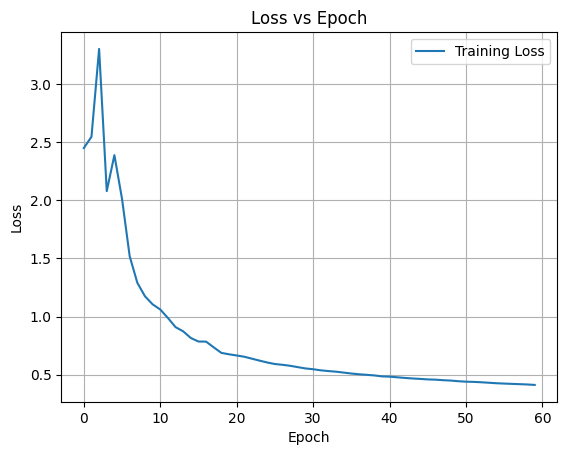

In [8]:
# find loss of the test sample

# plot the loss vs. epochs
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Save parameters for later prediction (weights and biases)
import pickle

with open("model_weights.pkl", "wb") as f:
    pickle.dump(params, f)

In [10]:
# Load parameters from saved file
with open("model_weights.pkl", "rb") as f:
    loaded_params = pickle.load(f)

In [11]:
# Preprocess input
x_input = x_test.reshape(x_test.shape[0], -1) / 255.0

# Use loaded weights to do forwardProp
A3_loaded, _ = my_forward_prop(x_input, loaded_params)

# Get predictions
predictions = np.argmax(A3_loaded, axis=1)

In [12]:
sample = x_test[0].reshape(1, -1) / 255.0
A3_single, _ = my_forward_prop(sample, loaded_params)
predicted_class = np.argmax(A3_single)
print(f"Predicted class: {predicted_class}")

Predicted class: 9


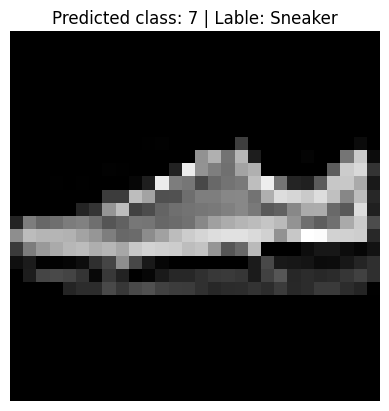

In [19]:
# Choose a test sample (e.g. index 0)
index = 9
sample_image = x_test[index]
sample_input = sample_image.reshape(1, -1) / 255.0

# Predict using our model
A3_single, _ = my_forward_prop(sample_input, loaded_params)
predicted_class = np.argmax(A3_single)

# Plot the image
plt.imshow(sample_image, cmap="gray")
plt.title(f"Predicted class: {predicted_class} | Lable: {class_names[predicted_class]}")
plt.axis("off")
plt.show()